# Risk Simulation

In [1]:
#packages
import pandas as pd
import numpy as np
import math
import random
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import *

Distribuciones de scipy y su documentación:
https://docs.scipy.org/doc/scipy/reference/stats.html

Distribuciones de numpy y su documentación:
https://numpy.org/doc/1.16/reference/routines.random.html

## Ajustar mejor distribución

In [2]:
#import volatilities
vols = pd.read_excel("vols.xlsx")
vols.head()

,Date,Coffee,COPUSD,CoffeeCOP
0,1991-01-03,0.285139,NaN,NaN
1,1991-01-04,0.285243,NaN,NaN
2,1991-01-07,0.285104,NaN,NaN
3,1991-01-08,0.284625,NaN,NaN
4,1991-01-09,0.284622,NaN,NaN


In [3]:
coffee = vols["Coffee"]
trm = vols["COPUSD"]
coffee_cop = vols["CoffeeCOP"]

coffee.dropna(inplace = True)
trm.dropna(inplace = True)
coffee_cop.dropna(inplace = True)

In [ ]:
%%time
from fitter import Fitter
f1 = Fitter(coffee)
f1.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f1.summary()

In [ ]:
%%time
f2 = Fitter(trm)
f2.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f2.summary()

In [ ]:
%%time
f3 = Fitter(coffee_cop)
f3.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f3.summary()

Obtener parametros para las mejores distribuciones

In [ ]:
print("Parms of coffee",f1.fitted_param['dgamma'])
print("Parms of trm", f2.fitted_param['fatiguelife'])
print("Parms of coffee cop",f3.fitted_param['laplace'])

In [10]:
#definir inputs:
n = 5000
pct_cobertura = 0.3

#IBR
ibr_min = 0.01
ibr_c = 0.035
ibr_max = 0.05
ibr = np.random.triangular(ibr_min, ibr_c, ibr_max, size=n)

#LIBOR
lib_min = 0
lib_c = 0.029
lib_max = 0.038
lib = np.random.triangular(lib_min, lib_c, lib_max, size=n)

#Vol Café
vol_coffee = dgamma.rvs(1.4863778547163755, loc = 0.356, scale = 0.0465, size=n)

#Vol Dólar
vol_trm = fatiguelife.rvs(0.5202 ,loc = 0.0139, scale = 0.0747, size = n)

#vol Cafe cop
vol_coffee_cop = laplace.rvs(loc = 0.2350, scale = 0.05825)


#precio café
#definir distribucion del café

#precio dólar
#definir distribucion del dolar - hacer browniano geométrico

## Black Scholes

In [11]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/sigma*sqrt(T)
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

In [12]:
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

## Simulación masiva

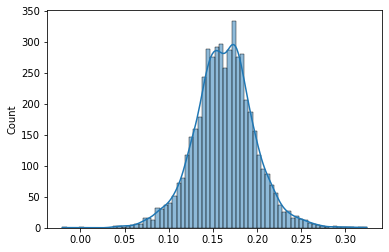

In [13]:
#simular primas café base
primas_pct = []

for i in range(n):
    ss = -0.02 #Strike vs Spot
    S = 100 #spot
    K = S*(1+ss) #strike
    T = 1 #time in years
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima = bs_call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
sns.histplot(primas_pct, kde=True)
plt.show()

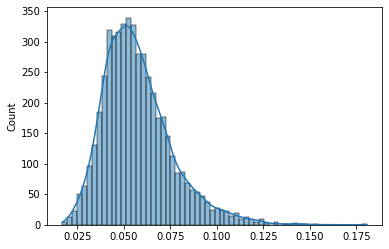

In [14]:
#simular primas trm
primas_pct = []

for i in range(n):
    ss = -0.02 #Strike vs Spot
    S = 3500 #spot
    K = S*(1+ss) #strike
    T = 1 #time in years
    r = ibr[i] - lib[i] #free risk interest rate
    sigma = vol_trm[i] #volatility of asset (annualized)
    prima = bs_call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
sns.histplot(primas_pct, kde=True)
plt.show()

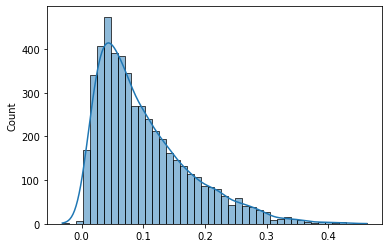

In [15]:
#inputs
S = 100 #spot coffee base
S2 = 3500 #spot trm base
T = 1 #time in years

#dist strike vs spot 
ss_array_coffee = np.random.triangular(-0.5, 0, 0.5, size=n) #Triangular con moda 0 min -50% y max +50%
ss_array_trm = np.random.triangular(-0.5, 0, 0.5, size=n) #Triangular con moda 0 min -50% y max +50%

#Combinacion de las dos primas
primas_pct = []
primas_pct2 = []
primas_pct_all = []


for i in range(n):
    #coffee
    ss =  ss_array_coffee[i] #Strike vs Spot
    K = S*(1+ss) #strike coffee
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima = bs_call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
    #trm
    ss2 = ss_array_trm[i]
    K2 = S2*(1+ss2)
    r2 = ibr[i] - lib[i]
    sigma2 = vol_trm[i]
    prima2 = bs_call(S2, K2, T, r2, sigma2)
    prima_pct2 = prima2 / K2
    primas_pct2.append(prima_pct2)
    
    #combinacion
    prima_pct_all = (prima_pct + prima_pct2)*pct_cobertura
    primas_pct_all.append(prima_pct_all)
    
    
    
sns.histplot(primas_pct_all, kde=True)
plt.show()

## Simulación de precios futuros

### Geometric Brownian Motion GBM

In [ ]:
# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in the prediction time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

### Simulación Precio Café

In [16]:
import quandl
quandl.ApiConfig.api_key = "1VS8Ys2-9xQMfabc_KfS"

In [17]:
start_date = '2000-01-01'
end_date = '2021-02-28'
pred_end_date = '2021-06-30'

# We get daily closing prices for Coffee C Futures
kc = quandl.get("CHRIS/ICE_KC1", start_date=start_date, 
                    end_date=end_date).reset_index(drop = False)[['Date', 'Settle']]

In [18]:
returns = (kc.loc[1:, 'Settle'] - \
           kc.shift(1).loc[1:, 'Settle']) / \
           kc.shift(1).loc[1:, 'Settle']


# Parameter Assignments
So = kc.loc[kc.shape[0] - 1, "Settle"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
Tb = n_of_wkdays # days  # User input -> follows from pred_end_date
N = Tb / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 10 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [19]:
drift = (mu - 0.5 * sigma**2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

In [20]:
# Making the predictions
S_c = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S_c = np.hstack((np.array([[So] for scen in range(scen_size)]), S_c)) # add So to the beginning series

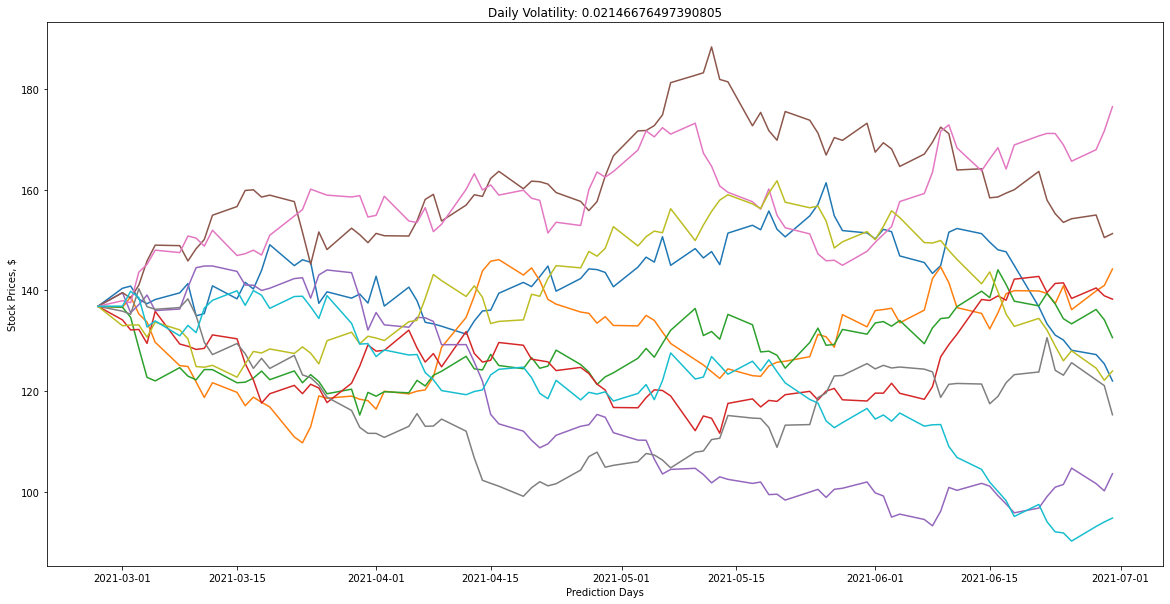

In [21]:

# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = kc["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S_c[i, :])
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S_c.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = kc["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

### Movimiento Browniano COP / USD

In [22]:
import investpy

In [23]:
start_datei = '01/01/2000'
end_datei = '28/02/2021'
pred_end_datei = '30/06/2021'


df = investpy.get_currency_cross_historical_data(currency_cross='USD/COP',
                                                 from_date=start_datei,
                                                 to_date=end_datei).reset_index(drop = False)[['Date', 'Close']]
df.tail()

,Date,Close
5505,2021-02-22,3591.00
5506,2021-02-23,3592.00
5507,2021-02-24,3562.50
5508,2021-02-25,3607.95
5509,2021-02-26,3644.50


In [24]:
returns_trm = df["Close"].pct_change().dropna()


# Parameter Assignments
So_trm = df.loc[df.shape[0] - 1, "Close"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_datei) + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_datei)).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()


Tb = n_of_wkdays # days  # User input -> follows from pred_end_date
N = Tb / dt
t = np.arange(1, int(N) + 1)
mu_trm = np.mean(returns_trm)
sigma_trm = np.std(returns_trm)
scen_size = 10 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

drift_trm = (mu_trm - 0.5 * sigma_trm**2) * t
diffusion_trm = {str(scen): sigma_trm * W[str(scen)] for scen in range(1, scen_size + 1)}

In [25]:
# Making the predictions
S_trm = np.array([So_trm * np.exp(drift_trm + diffusion_trm[str(scen)]) for scen in range(1, scen_size + 1)]) 
S_trm = np.hstack((np.array([[So_trm] for scen in range(scen_size)]), S_trm)) # add So to the beginning series

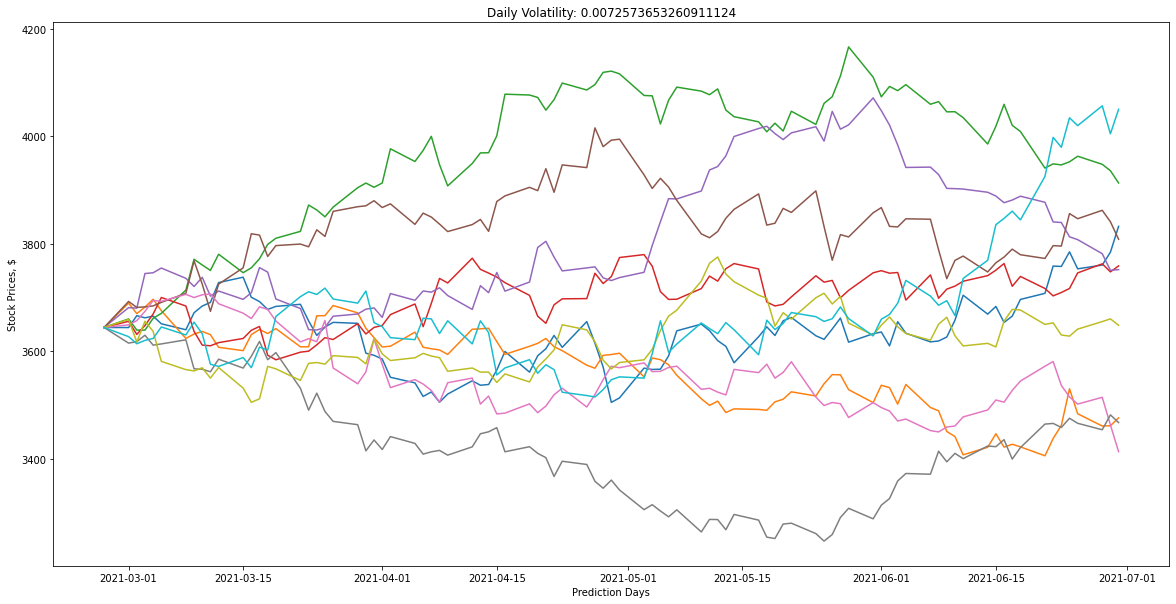

In [26]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma_trm))
    plt.plot(pd.date_range(start = df["Date"].max(), 
                end = pred_end_datei, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S_trm[i, :])
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S_trm.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = df["Date"].max(), 
           end = pred_end_datei, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

In [67]:
#inputs
S = So #spot coffee base
S2 = So_trm #spot trm base
T = Tb / 365 #time in years

#dist strike vs spot 
max_days = 15
ss_coffee = S_c[random.randint(0,scen_size-1)][random.randint(1,max_days)]
ss_trm = S_trm[random.randint(0,scen_size-1)][random.randint(1,max_days)]




17779.21255329532
13360565.782306397


## Simulación P&G

### Compra Opción con parámetros aleatorios

In [83]:
#inputs
S = So #spot coffee base
S2 = So_trm #spot trm base
T = Tb / 365 #time in years

#dist strike vs spot 
max_days = 15
chosen_scen = random.randint(0,scen_size-1)
days_gone = random.randint(1,max_days)


ss_coffee = S_c[chosen_scen][days_gone]
ss_trm = S_trm[chosen_scen][days_gone]



K = ss_coffee #strike coffee
K2 = ss_trm

#Combinacion de las dos primas
primas_pct = []
primas_pct2 = []
primas_pct_all = []


for i in range(n):
    #coffee
    r = lib[i] #free risk interest rate
    sigma = vol_coffee[i] #volatility of asset (annualized)
    prima = bs_call(S,K,T,r,sigma) # price of option in unites
    prima_pct = prima / K #price of option %
    primas_pct.append(prima_pct)
    
    #trm
    r2 = ibr[i] - lib[i]
    sigma2 = vol_trm[i]
    prima2 = bs_call(S2, K2, T, r2, sigma2)
    prima_pct2 = prima2 / K2
    primas_pct2.append(prima_pct2)
    
    #combinacion
    prima_pct_all = (prima_pct + prima_pct2)
    primas_pct_all.append(prima_pct_all)

In [84]:
primas_pct_all_arr = np.array(primas_pct_all)
prima_avg = primas_pct_all_arr.mean()
print("Escenario Escogido",chosen_scen)
print("Días pasados entre strike y spot",days_gone)
print("Spot café", So, "Strike Café", K)
print("Spot TRM", So_trm, "Strike trm", K2)
print("Costo prima promedio cobertura", round(prima_avg * 100,3), "%")

Escenario Escogido 2
Días pasados entre strike y spot 10
Spot café 136.85 Strike Café 124.27704032104154
Spot TRM 3644.5 Strike trm 3780.646493835912
Costo prima promedio cobertura 13.436 %


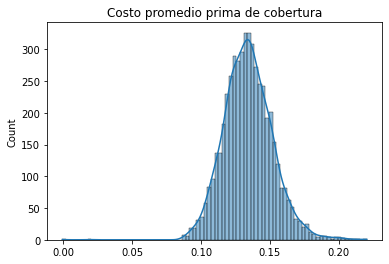

In [85]:
sns.histplot(primas_pct_all, kde=True)
plt.title("Costo promedio prima de cobertura")
plt.show()

Costo de capital

In [88]:
p995 = np.percentile(primas_pct_all_arr, 99.5)
KdC = 0.15
taxes = 0.7
margen = (p995 - prima_avg)*KdC
prima_obj = ((prima_avg + margen)/taxes)*pct_cobertura
print("Costo Objetivo", round(prima_obj,3)*100, "%")

Costo Objetivo 6.1 %
